In [2]:
!pip install geopandas
!pip install fiona
!pip install pandas
!pip install pyproj
!pip install os
!pip install shapely
!pip install unary_union

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 97.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
ERROR: Could not find a version that satisfies the requirement unary_union (from versions: none)
ERROR: No matching distribution found for unary_union


In [3]:
import geopandas as gpd
import fiona
import pandas as pd
import pyproj
import os
from shapely.geometry import shape
from shapely.ops import split, unary_union

In [4]:
import time

def time_it(func):
    """
    A decorator function to measure the execution time of a given function.

    Args:
        func: The function whose execution time needs to be measured.

    Returns:
        A wrapped version of the input function that prints the execution time.
    """
    def wrapper(*args, **kwargs):
        # Record the start time
        start_time = time.time()

        # Call the original function with its arguments
        result = func(*args, **kwargs)

        # Record the end time
        end_time = time.time()

        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' took {elapsed_time:.6f} seconds to execute.")

        # Return the result of the original function
        return result

    return wrapper


In [5]:
pd.set_option('display.max_columns', None)


# Prep Munc Function

In [36]:
@time_it
def prep_muni(df_muni,model_area_df,prov):
  muni_df = df_muni[df_muni['PROV']==prov].sort_values('NAME')
  model_area_lut = muni_df[['UNIQUE_ID','NAME','PROV','geometry']]

  if prov == "BC":
    pass

  model_areas = model_area_df
  model_area_lut['Obj_Npolygons'] = model_area_lut.geometry.apply(lambda g: 1 if g.geom_type == "Polygon" else len(g.geoms))
  multi_polys = model_area_lut[model_area_lut['Obj_Npolygons']>1]
  multi_polys = multi_polys.explode(index_parts = False).reset_index(drop=True)
  multi_polys = multi_polys.sjoin(model_areas[['ModelAreaName','geometry']],how='left',predicate='intersects')
  multi_polys['TempName'] = multi_polys['ModelAreaName']+"_"+multi_polys['NAME']
  merged = multi_polys.dissolve(by='TempName',as_index = False)
  merged = merged[['UNIQUE_ID','NAME','PROV','ModelAreaName','geometry']]
  model_area_lut = pd.concat([model_area_lut[model_area_lut['Obj_Npolygons']==1],merged],ignore_index=True)
  model_area_lut= model_area_lut.drop(columns=['Obj_Npolygons'])
  model_area_lut.to_file("ModelAreaLUT", driver="MapInfo File")
  print("Municipality lookup table created for Alberta (AB) in MapInfo TAB format at")
  return model_area_lut



In [37]:
muni_df = gpd.read_file("MunicipalitiesRegion.tab", driver='MapInfo File') # Explicitly specify the MapInfo File driver
prov_list = ["AB"]
for prov in prov_list:
  model_areas = gpd.read_file(f"ModelAreas_{prov}.TAB", driver='MapInfo File')
  model_area_lut = prep_muni(muni_df,model_areas,prov)


Municipality lookup table created for Alberta (AB) in MapInfo TAB format at
Function 'prep_muni' took 0.135369 seconds to execute.


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Plot Map
Check which area fall outside the

In [21]:
outside_polygons = multi_polys[multi_polys['ModelAreaName'].isna()]

<ipython-input-71-827b568daff1>:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-71-827b568daff1>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


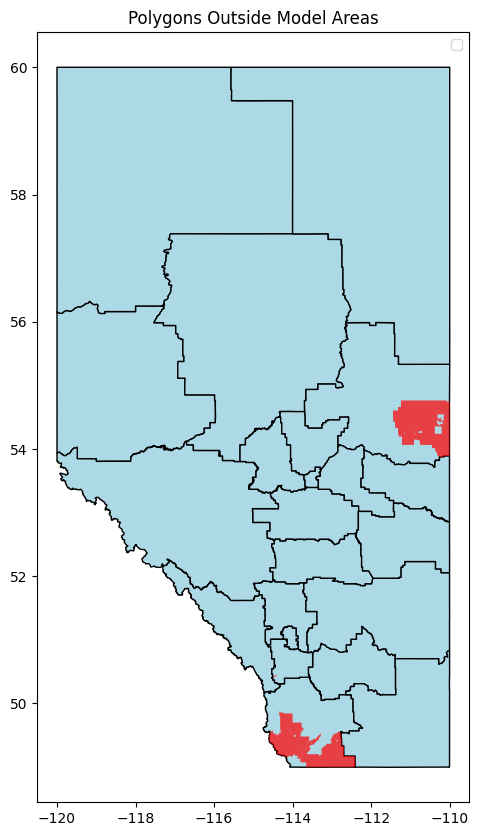

In [ ]:
import matplotlib.pyplot as plt

# Plot the model_areas
fig, ax = plt.subplots(figsize=(10, 10))
model_areas.plot(ax=ax, color='lightblue', edgecolor='black', label='Model Areas')

# Plot the outside polygons
outside_polygons.plot(ax=ax, color='red', alpha=0.7, label='Outside Polygons')

# Add legend and title
plt.legend()
plt.title('Polygons Outside Model Areas')
plt.show()

In [ ]:
print(model_areas.is_valid.all())

True


# Convert MAPinfo file to jeoson


In [ ]:
import geopandas as gpd

# Read the .TAB file
tab_file = "BoundaryUpgradeLog.TAB"
gdf = gpd.read_file(tab_file)

# Convert to GeoJSON
geojson_file = "output.geojson"
gdf.to_file(geojson_file, driver="GeoJSON")

print(f"GeoJSON file saved to {geojson_file}")


GeoJSON file saved to output.geojson


In [53]:
import geopandas as gpd
file_list = ["BoundaryUpgradeLog.TAB","UrbanAreas_AB.TAB","SuppBoundsFINAL.TAB","UrbanAreas_PROV2.TAB"]
for file in file_list:
  gdf = gpd.read_file(file)
  geojson_file = file.split(".")[0]+".geojson"
  gdf.to_file(geojson_file, driver="GeoJSON")
  print(f"GeoJSON file saved to {geojson_file}")

GeoJSON file saved to BoundaryUpgradeLog.geojson
GeoJSON file saved to UrbanAreas_AB.geojson
GeoJSON file saved to SuppBoundsFINAL.geojson
GeoJSON file saved to UrbanAreas_PROV2.geojson


# Create a map with Layers in Folium

In [54]:
def boundary_style(feature):
  return {
  'fillColor': 'blue',
  'color': 'blue',
  'weight': 2,
  'opacity': 1,
  'fillOpacity': 0.6}

def urban_areas_style(feature):
  return {
  'fillColor': 'green',
  'color': 'green',
  'weight': 2,
  'opacity': 1,
  'fillOpacity': 0.6
  }

def supp_style(feature):
  return {
  'fillColor': 'red',
  'color': 'red',
  'weight': 2,
  'opacity': 1,
  'fillOpacity': 0.6
  }

def urban_style(feature):
  return {
  'fillColor': 'yellow',
  'color': 'yellow',
  'weight': 2,
  'opacity': 1,
  'fillOpacity': 0.6
  }

In [55]:
import folium
import json

# Create a map centered around a specific location
m = folium.Map(location=[45.4215, -75.6972], zoom_start=13)

# Open the GeoJSON file and load the data using json.load()
with open("BoundaryUpgradeLog.geojson") as f:
    BoundaryUpgradeLog = json.load(f)

with open("UrbanAreas_AB.geojson") as f:
    UrbanAreas_AB = json.load(f)

with open("SuppBoundsFINAL.geojson") as f:
    supp = json.load(f)

with open("UrbanAreas_PROV2.geojson") as f:
    urban = json.load(f)

# Add the GeoJSON layer (boundary layer)
folium.GeoJson(BoundaryUpgradeLog, name='Boundary Layer',style_function=boundary_style).add_to(m)
folium.GeoJson(UrbanAreas_AB, name='Urban Areas AB Layer',style_function=urban_areas_style).add_to(m)
folium.GeoJson(supp, name='supp',style_function=supp_style).add_to(m)
folium.GeoJson(urban, name='urban',style_function=urban_style).add_to(m)
# Add layer control to toggle the boundary layer
folium.LayerControl().add_to(m)





# Save the map to an HTML file
m.save('map_with_geojson.html')
